# Declaration of Originality

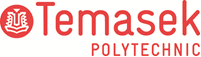

**TEMASEK POLYTECHNIC**
<br>**SCHOOL OF INFORMATICS & IT**
<br>**DIPLOMA IN INFORMATION TECHNOLOGY**
<br>**MACHINE LEARNING FOR DEVELOPERS (CAI2C08)**
<br>**AY2025/2026 OCTOBER SEMESTER**

**PROJECT PROGRAM CODES**
* Student Name (Matric Number)  : Aung Hpone Pyaye (2403576H)
* Tutorial Group                : TC02
* Tutor						    : Ester GOH
* Submission Date               : 2/11/2026


**Declaration of Originality**
* I am the originator of this work and I have appropriately acknowledged all other original sources used as my references for this work.
* I understand that Plagiarism is the act of taking and using the whole or any part of another personÃ¢â‚¬â„¢s work, including work generated by AI, and presenting it as my own.
* I understand that Plagiarism is an academic offence and if I am found to have committed or abetted the offence of plagiarism in relation to this submitted work, disciplinary action will be enforced.

# Libraries

In [1]:
## Import libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

import joblib

warnings.filterwarnings("ignore")

RANDOM_STATE = 2025
sns.set_theme(style="whitegrid")

os.makedirs("../outputs/figures", exist_ok=True)
os.makedirs("../outputs/models", exist_ok=True)


# 1. Business Understanding
Goal: Predict customer churn (`Churn`) for a telco company so the business can identify customers at risk of leaving and plan retention actions.

Task type: **Binary Classification** (`Yes`/`No` churn).

Business objective:
- Reduce churn rate by identifying high-risk customers early.
- Prioritize retention resources based on model predictions.
- Use explainable baseline model first, then improve with ensemble and tuning.


# 2. Data Understanding

## 2.1 Load dataset

In [2]:
## Read *.csv file into pandas DataFrame
DATA_PATH = "../data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

print(f"Shape: {df.shape}")
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2.2 Summary Statistics

In [3]:
## Understand the type of variable for each column
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
## Check for missing data
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

missing_isnull = df.isnull().sum()
missing_isna = df.isna().sum()

missing_df = pd.DataFrame({
    "isnull_count": missing_isnull,
    "isna_count": missing_isna,
})
missing_df["missing_pct"] = (missing_df["isna_count"] / len(df) * 100).round(2)
missing_df = missing_df.sort_values("missing_pct", ascending=False)

print("Missing values using isnull():")
print(missing_isnull[missing_isnull > 0])
print("\nMissing values using isna():")
print(missing_isna[missing_isna > 0])

missing_df.head(10)


Missing values using isnull():
TotalCharges    11
dtype: int64

Missing values using isna():
TotalCharges    11
dtype: int64


,isnull_count,isna_count,missing_pct
TotalCharges,11,11,0.16
customerID,0,0,0.00
DeviceProtection,0,0,0.00
MonthlyCharges,0,0,0.00
PaymentMethod,0,0,0.00
PaperlessBilling,0,0,0.00
Contract,0,0,0.00
StreamingMovies,0,0,0.00
StreamingTV,0,0,0.00
TechSupport,0,0,0.00


In [5]:
## Describe data distribution
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.3 Data Visualization

### 2.3.1 Understanding distribution of data

### 2.3.1.1 Understanding distribution of target

Target counts:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64

Target %:
 Churn
No     73.46
Yes    26.54
Name: proportion, dtype: float64


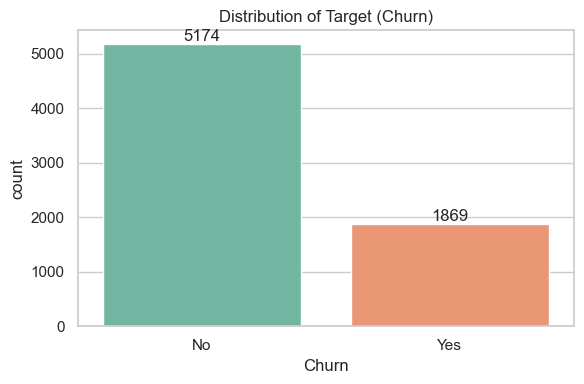

In [6]:
## Understanding distribution of target
df["Churn_bin"] = df["Churn"].map({"No": 0, "Yes": 1})

target_counts = df["Churn"].value_counts()
target_pct = (df["Churn"].value_counts(normalize=True) * 100).round(2)

print("Target counts:\n", target_counts)
print("\nTarget %:\n", target_pct)

plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x="Churn", palette="Set2")
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom"
    )
plt.title("Distribution of Target (Churn)")
plt.tight_layout()
plt.savefig("../outputs/figures/churn_distribution.png", dpi=120)
plt.show()


### 2.3.1.2 Understanding distribution of features

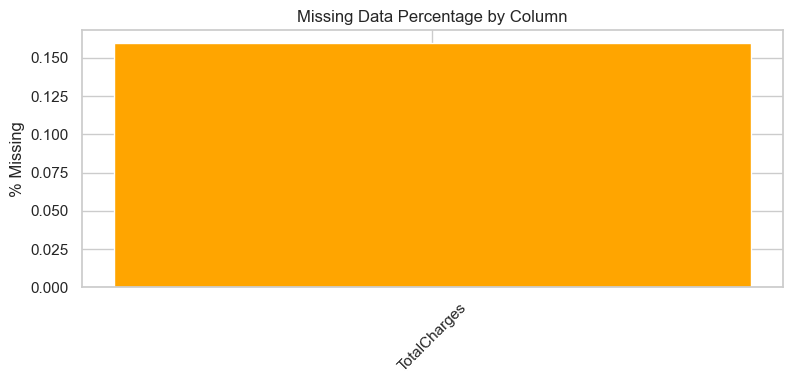

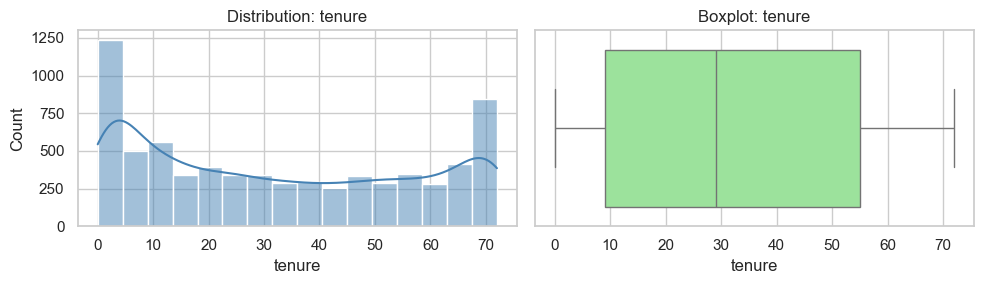

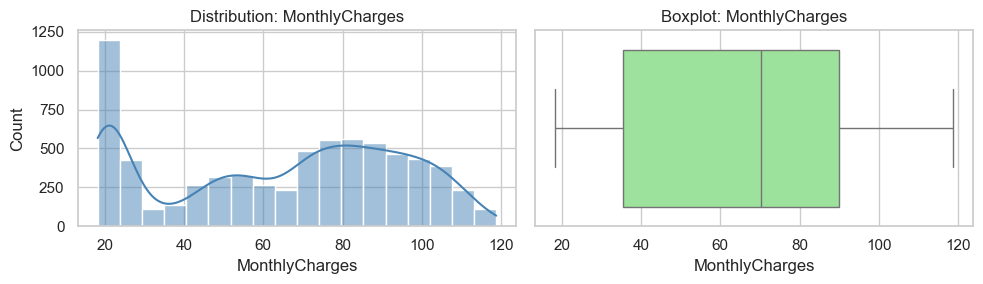

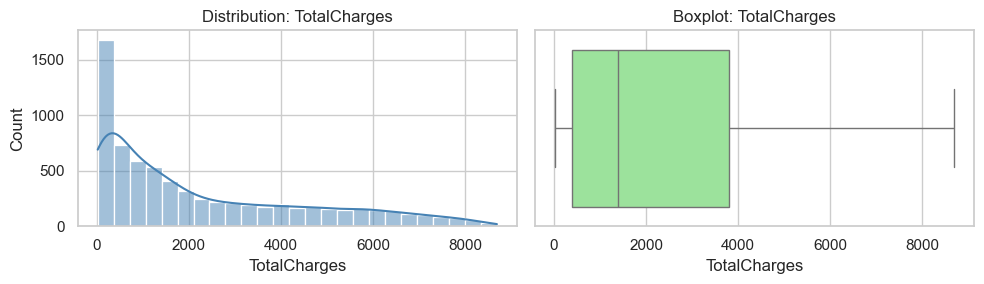

,feature,outlier_count,outlier_pct
0,tenure,0,0.0
1,MonthlyCharges,0,0.0
2,TotalCharges,0,0.0


In [7]:
## Understanding distribution of features
plt.figure(figsize=(8, 4))
missing_plot = missing_df[missing_df["missing_pct"] > 0]
if len(missing_plot) > 0:
    plt.bar(missing_plot.index, missing_plot["missing_pct"], color="orange")
    plt.title("Missing Data Percentage by Column")
    plt.ylabel("% Missing")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("../outputs/figures/missing_data.png", dpi=120)
    plt.show()

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sns.histplot(df[col], kde=True, ax=axes[0], color="steelblue")
    axes[0].set_title(f"Distribution: {col}")

    sns.boxplot(x=df[col], ax=axes[1], color="lightgreen")
    axes[1].set_title(f"Boxplot: {col}")

    plt.tight_layout()
    plt.savefig(f"../outputs/figures/dist_box_{col}.png", dpi=120)
    plt.show()

outlier_summary = []
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary.append({
        "feature": col,
        "outlier_count": int(outliers),
        "outlier_pct": round(outliers / len(df) * 100, 2)
    })

pd.DataFrame(outlier_summary)


### 2.3.2 Understanding relationship between variables

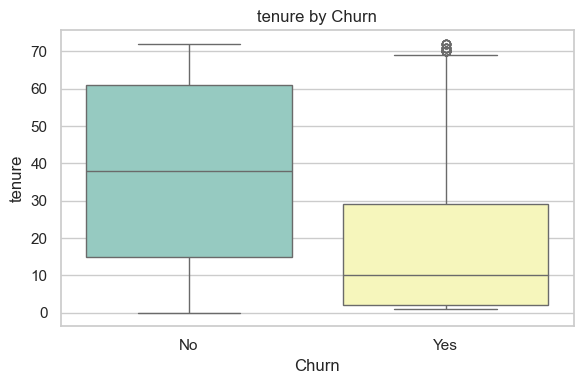

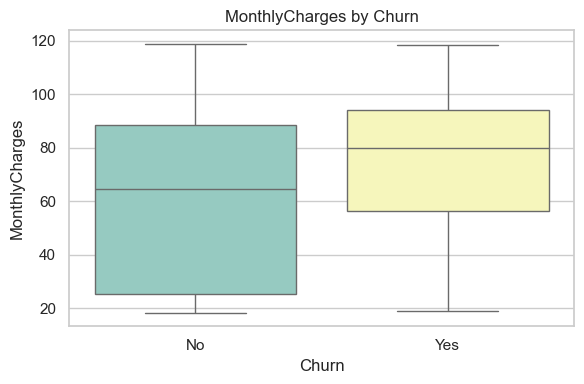

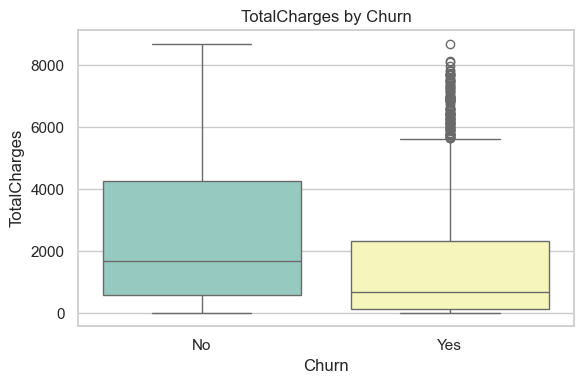

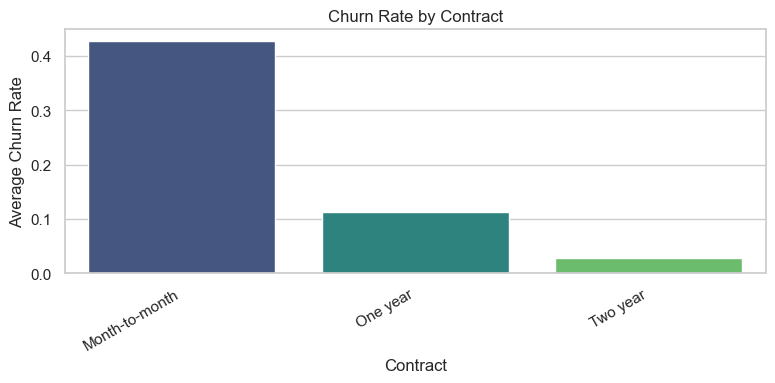

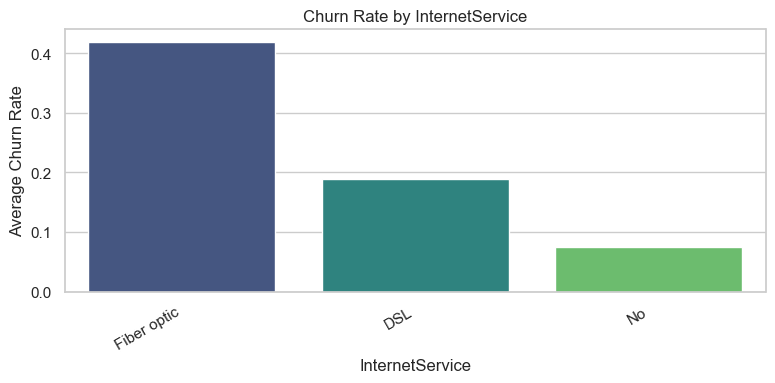

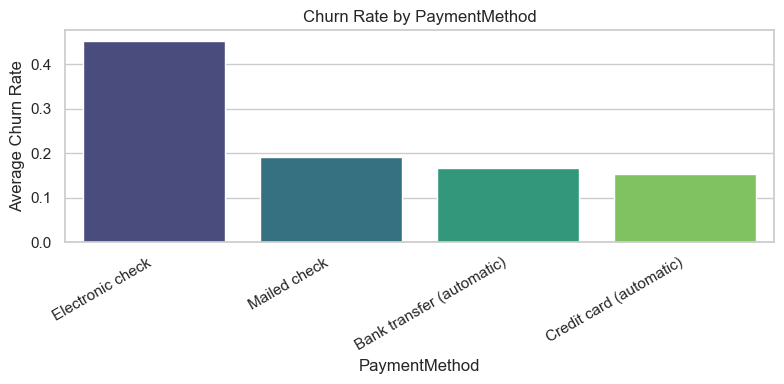

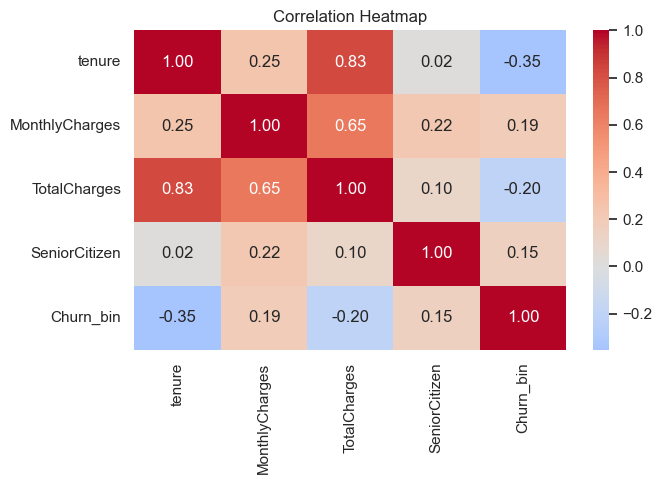

In [8]:
## Understanding relationship between variables
for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x="Churn", y=col, palette="Set3")
    plt.title(f"{col} by Churn")
    plt.tight_layout()
    plt.savefig(f"../outputs/figures/{col}_by_churn.png", dpi=120)
    plt.show()

for col in ["Contract", "InternetService", "PaymentMethod"]:
    churn_rate = (
        df.groupby(col)["Churn_bin"].mean()
        .sort_values(ascending=False)
        .reset_index()
    )
    plt.figure(figsize=(8, 4))
    sns.barplot(data=churn_rate, x=col, y="Churn_bin", palette="viridis")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Average Churn Rate")
    plt.title(f"Churn Rate by {col}")
    plt.tight_layout()
    plt.savefig(f"../outputs/figures/churn_rate_{col}.png", dpi=120)
    plt.show()

corr_cols = ["tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen", "Churn_bin"]
plt.figure(figsize=(7, 5))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("../outputs/figures/correlation_heatmap.png", dpi=120)
plt.show()


# 3. Data Preparation

## 3.1 Data Cleaning

In [9]:
## Clean data
df_raw = df.copy()
df = df.drop(columns=["customerID"])

X = df.drop(columns=["Churn", "Churn_bin"])
y = df["Churn_bin"]

categorical_features = X.select_dtypes(include="object").columns.tolist()
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical features:", len(categorical_features))
print("Numeric features:", len(numeric_features))

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


Categorical features: 15
Numeric features: 4


## 3.2 Train-Test Split

In [10]:
## Split data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train churn rate:", round(y_train.mean(), 4))
print("Test churn rate:", round(y_test.mean(), 4))


Train shape: (5634, 19)
Test shape: (1409, 19)
Train churn rate: 0.2654
Test churn rate: 0.2654


# 4. Modelling

### 4.2 Train Model

In [11]:
## Initialise and train model
baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
])

baseline_model.fit(X_train, y_train)
print("Baseline model trained.")


Baseline model trained.


# 5. Model Evaluation


Logistic Regression (Baseline) Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



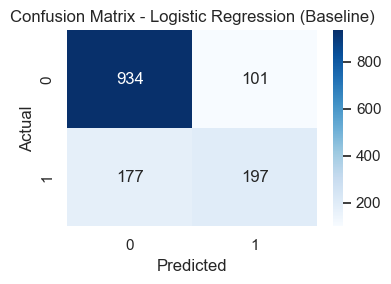

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression (Baseline),0.802697,0.661074,0.526738,0.58631,0.842114


In [12]:
## Evaluate model

def evaluate_model(model, X_eval, y_eval, model_name="Model"):
    y_pred = model.predict(X_eval)
    y_prob = model.predict_proba(X_eval)[:, 1] if hasattr(model, "predict_proba") else None

    results = {
        "model": model_name,
        "accuracy": accuracy_score(y_eval, y_pred),
        "precision": precision_score(y_eval, y_pred),
        "recall": recall_score(y_eval, y_pred),
        "f1": f1_score(y_eval, y_pred),
        "roc_auc": roc_auc_score(y_eval, y_prob) if y_prob is not None else np.nan,
    }

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_eval, y_pred))

    cm = confusion_matrix(y_eval, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"../outputs/figures/confusion_matrix_{model_name.replace(' ', '_').lower()}.png", dpi=120)
    plt.show()

    return results

# Metric selection rationale:
# Churn dataset is moderately imbalanced, so F1 is selected as the primary metric.
baseline_results = evaluate_model(baseline_model, X_test, y_test, "Logistic Regression (Baseline)")
pd.DataFrame([baseline_results])


In [13]:
## New data

## Predict
new_customer = pd.DataFrame([
    {
        "gender": "Female",
        "SeniorCitizen": 0,
        "Partner": "Yes",
        "Dependents": "No",
        "tenure": 12,
        "PhoneService": "Yes",
        "MultipleLines": "No",
        "InternetService": "Fiber optic",
        "OnlineSecurity": "No",
        "OnlineBackup": "Yes",
        "DeviceProtection": "No",
        "TechSupport": "No",
        "StreamingTV": "Yes",
        "StreamingMovies": "Yes",
        "Contract": "Month-to-month",
        "PaperlessBilling": "Yes",
        "PaymentMethod": "Electronic check",
        "MonthlyCharges": 85.2,
        "TotalCharges": 1024.8,
    }
])

new_pred = baseline_model.predict(new_customer)[0]
new_prob = baseline_model.predict_proba(new_customer)[0, 1]

print("Predicted Churn:", "Yes" if new_pred == 1 else "No")
print("Churn Probability:", round(float(new_prob), 4))


Predicted Churn: Yes
Churn Probability: 0.6623


## Iterative model development
We iteratively improve from a baseline Logistic Regression to ensemble models, then add feature engineering and hyperparameter tuning (`RandomizedSearchCV`) based on the chosen metric.



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.65      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



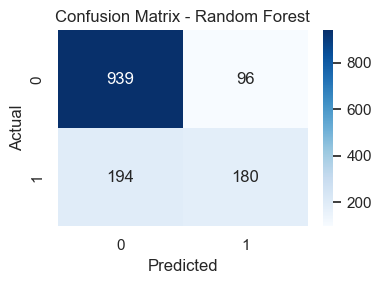


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



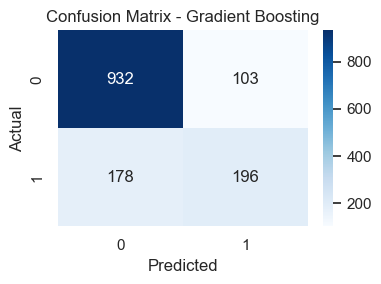


Model comparison sorted by F1:
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params:
{'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_features': None, 'model__max_depth': 8}
Best CV F1: 0.5686

Random Forest (FE + Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.64      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.78      1409



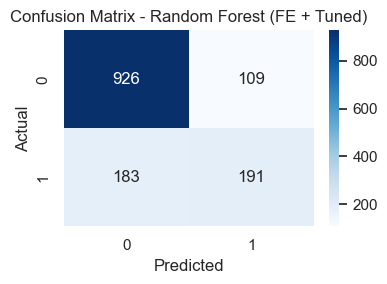


Final model ranking by F1:


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression (Baseline),0.802697,0.661074,0.526738,0.586310,0.842114
2,Gradient Boosting,0.800568,0.655518,0.524064,0.582467,0.845616
3,Random Forest (FE + Tuned),0.792761,0.636667,0.510695,0.566766,0.836614
1,Random Forest,0.794180,0.652174,0.481283,0.553846,0.811891


In [14]:
## Further feature engineering / feature selection
candidate_models = {
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
}

all_results = [baseline_results]
for name, clf in candidate_models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", clf),
    ])
    pipe.fit(X_train, y_train)
    res = evaluate_model(pipe, X_test, y_test, name)
    all_results.append(res)

results_df = pd.DataFrame(all_results).sort_values("f1", ascending=False)
print("\nModel comparison sorted by F1:")
results_df

def add_features(dataframe):
    d = dataframe.copy()
    d["avg_charge_per_tenure"] = d["TotalCharges"] / (d["tenure"] + 1)
    d["is_new_customer"] = (d["tenure"] <= 12).astype(int)
    d["service_count"] = (
        (d["PhoneService"] == "Yes").astype(int)
        + (d["OnlineSecurity"] == "Yes").astype(int)
        + (d["OnlineBackup"] == "Yes").astype(int)
        + (d["DeviceProtection"] == "Yes").astype(int)
        + (d["TechSupport"] == "Yes").astype(int)
        + (d["StreamingTV"] == "Yes").astype(int)
        + (d["StreamingMovies"] == "Yes").astype(int)
    )
    return d

# Model refinement + tuning on FE pipeline (tutorial-aligned)
fe_pipe = Pipeline(steps=[
    ("feature_engineering", FunctionTransformer(add_features, validate=False)),
    (
        "preprocessor",
        ColumnTransformer(
            transformers=[
                (
                    "num",
                    Pipeline(steps=[
                        ("imputer", SimpleImputer(strategy="median")),
                        ("scaler", StandardScaler()),
                    ]),
                    ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges", "avg_charge_per_tenure", "is_new_customer", "service_count"],
                ),
                (
                    "cat",
                    Pipeline(steps=[
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("ohe", OneHotEncoder(handle_unknown="ignore")),
                    ]),
                    [
                        "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
                        "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
                        "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
                        "PaperlessBilling", "PaymentMethod"
                    ],
                ),
            ]
        ),
    ),
    ("model", RandomForestClassifier(random_state=RANDOM_STATE)),
])

param_dist = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 8, 16],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None],
}

random_search = RandomizedSearchCV(
    estimator=fe_pipe,
    param_distributions=param_dist,
    n_iter=12,
    scoring="f1",
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
)

random_search.fit(X_train, y_train)

print("Best params:")
print(random_search.best_params_)
print("Best CV F1:", round(random_search.best_score_, 4))

tuned_model = random_search.best_estimator_
tuned_results = evaluate_model(tuned_model, X_test, y_test, "Random Forest (FE + Tuned)")

final_results = pd.DataFrame(all_results + [tuned_results]).sort_values("f1", ascending=False)
print("\nFinal model ranking by F1:")
final_results


In [15]:
# Save deployment-safe model for Streamlit
# Use tuned hyperparameters, but train a final pipeline without FunctionTransformer in the saved pickle.

rf_params = {
    k.replace("model__", ""): v
    for k, v in random_search.best_params_.items()
    if k.startswith("model__")
}

X_train_fe = add_features(X_train)
X_test_fe = add_features(X_test)

deploy_numeric_cols = [
    "SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges",
    "avg_charge_per_tenure", "is_new_customer", "service_count"
]
deploy_categorical_cols = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod"
]

deploy_preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]),
            deploy_numeric_cols,
        ),
        (
            "cat",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore")),
            ]),
            deploy_categorical_cols,
        ),
    ]
)

deployment_model = Pipeline(steps=[
    ("preprocessor", deploy_preprocessor),
    ("model", RandomForestClassifier(random_state=RANDOM_STATE, **rf_params)),
])

deployment_model.fit(X_train_fe, y_train)
deploy_results = evaluate_model(deployment_model, X_test_fe, y_test, "Random Forest (Deployment-Safe)")

MODEL_PATH = "../outputs/models/telco_churn_model.pkl"
joblib.dump(deployment_model, MODEL_PATH)
print(f"Saved model to: {MODEL_PATH}")

print("\nSelected final model: Random Forest (Feature Engineering + RandomizedSearchCV)")
print("Primary metric: F1 score")
print("Saved deployment-safe pipeline for Streamlit.")
print("Deployment model test F1:", round(deploy_results["f1"], 4))


Saved model to: ../outputs/models/telco_churn_model.pkl

Selected final model: Random Forest (Feature Engineering + RandomizedSearchCV)
Primary metric: F1 score
Use this saved pipeline directly in Streamlit for prediction.
